In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtSmall, ResNet50, DenseNet201
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam 
import matplotlib as plt



In [2]:
load_data=tf.keras.preprocessing.image.ImageDataGenerator( 
    rescale=1/255.0, 
    brightness_range=[0.8,1.2], 
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.175,  
    horizontal_flip=True,  
    validation_split=0

)

In [3]:
train_data=load_data.flow_from_directory(
    './train', 
    target_size=(220, 220),
    batch_size=16,
    subset='training',  # Use the training subset
    class_mode='categorical',  # Use 'binary' for binary classification
    shuffle=True, ) 
val_data = load_data.flow_from_directory(
    './train', 
    target_size=(220, 220),
    batch_size=16,
    subset='validation',  # Use the validation subset
    class_mode='categorical',  # Use 'binary' for binary classification
    
)

Found 15557 images belonging to 23 classes.
Found 0 images belonging to 23 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtSmall, ResNet50, DenseNet201
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input layer
input_layer = Input(shape=(96, 96, 3))

# Load pre-trained models WITHOUT their top layers
convnext_base = ConvNeXtSmall(weights="imagenet", include_top=False, input_shape=(96, 96, 3))
resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=(96, 96, 3))
densenet_base = DenseNet201(weights="imagenet", include_top=False, input_shape=(96, 96, 3))
def freeze_layers(model, freeze_ratio):
    """Freeze the lower 'freeze_ratio' portion of layers in the model."""
    total_layers = len(model.layers)
    freeze_until = int(total_layers * freeze_ratio)
    for i, layer in enumerate(model.layers):
        layer.trainable = i >= freeze_until  # Unfreeze only the top layers

# Apply layer freezing
freeze_layers(convnext_base, freeze_ratio=0.8)
freeze_layers(resnet_base, freeze_ratio=0.8)
freeze_layers(densenet_base, freeze_ratio=0.8)

# Apply the shared input to all models
convnext_features = GlobalAveragePooling2D()(convnext_base(input_layer))
resnet_features = GlobalAveragePooling2D()(resnet_base(input_layer))
densenet_features = GlobalAveragePooling2D()(densenet_base(input_layer))

# ✅ Fix: Concatenate the outputs of all models
merged_features = Concatenate()([convnext_features, resnet_features, densenet_features])

# ✅ Fix: Pass concatenated features through dense neural network (meta-model)
x = Dense(256, activation="relu")(merged_features)  # Reduce from 512 to 256
x = Dropout(0.4)(x)  # Keep dropout to prevent overfitting
x = Dense(128, activation="relu")(x)  # Keep only one additional layer
x = Dropout(0.2)(x)

# ✅ Fix: Final softmax classification layer
final_output = Dense(23, activation="softmax")(x)

# Build the corrected unified model
ensemble_model = Model(inputs=input_layer, outputs=final_output)

# Compile the model with Top-3 accuracy
ensemble_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=3)]
)

# Print summary to verify structure
ensemble_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 convnext_small (Functional)    (None, 3, 3, 768)    49454688    ['input_1[0][0]']                
                                                                                                  
 resnet50 (Functional)          (None, 3, 3, 2048)   23587712    ['input_1[0][0]']                
                                                                                                  
 densenet201 (Functional)       (None, 3, 3, 1920)   18321984    ['input_1[0][0]']                
                                                                                              

In [7]:
history = ensemble_model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=40,  # Adjust as needed
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('model_checkpoint.h5', save_best_only=True, monitor='val_loss')
    ]
) 
history_dict = history.history

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


Epoch 1/40
972/972 [==============================] - 409s 420ms/step - loss: 2.3224 - accuracy: 0.3237 - top_k_categorical_accuracy: 0.5451
Epoch 2/40
972/972 [==============================] - 410s 421ms/step - loss: 2.1415 - accuracy: 0.3724 - top_k_categorical_accuracy: 0.6061
Epoch 3/40
972/972 [==============================] - 409s 421ms/step - loss: 1.9874 - accuracy: 0.4154 - top_k_categorical_accuracy: 0.6476
Epoch 4/40
972/972 [==============================] - 409s 420ms/step - loss: 1.8421 - accuracy: 0.4549 - top_k_categorical_accuracy: 0.6941
Epoch 5/40
972/972 [==============================] - 408s 420ms/step - loss: 1.7057 - accuracy: 0.4991 - top_k_categorical_accuracy: 0.7268
Epoch 6/40
972/972 [==============================] - 408s 420ms/step - loss: 1.5668 - accuracy: 0.5393 - top_k_categorical_accuracy: 0.7640
Epoch 7/40
972/972 [==============================] - 408s 420ms/step - loss: 1.4527 - accuracy: 0.5697 - top_k_categorical_accuracy: 0.7900
Epoch 8/40
97

AttributeError: module 'matplotlib' has no attribute 'figure'

In [8]:
# ✅ Only rescale test images (no augmentation)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

test_data = test_gen.flow_from_directory(
    './test',  # ✅ Path to test dataset
    target_size=(220, 220),
    batch_size=16,
    class_mode='categorical',  # ✅ Multi-class classification
    shuffle=False  # ✅ Do not shuffle for accurate evaluation
)


Found 4002 images belonging to 23 classes.


251/251 [==============================] - 108s 429ms/step - loss: 2.1951 - accuracy: 0.5835 - top_k_categorical_accuracy: 0.7666
Test Results: [2.1951310634613037, 0.5834582448005676, 0.766616702079773]
Test Loss: 2.1951
Test Accuracy: 0.5835
251/251 [==============================] - 126s 463ms/step

Classification Report:
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.80      0.93      0.86       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.68      0.65      0.66       288
                                          Atopic Dermatitis Photos       0.41      0.55      0.47       123
                                            Bullous Disease Photos       0.56      0.47      0.51       113
                Cellulitis Impetigo and other Bacterial Infections       0.33      0.44      0.38        73
                        

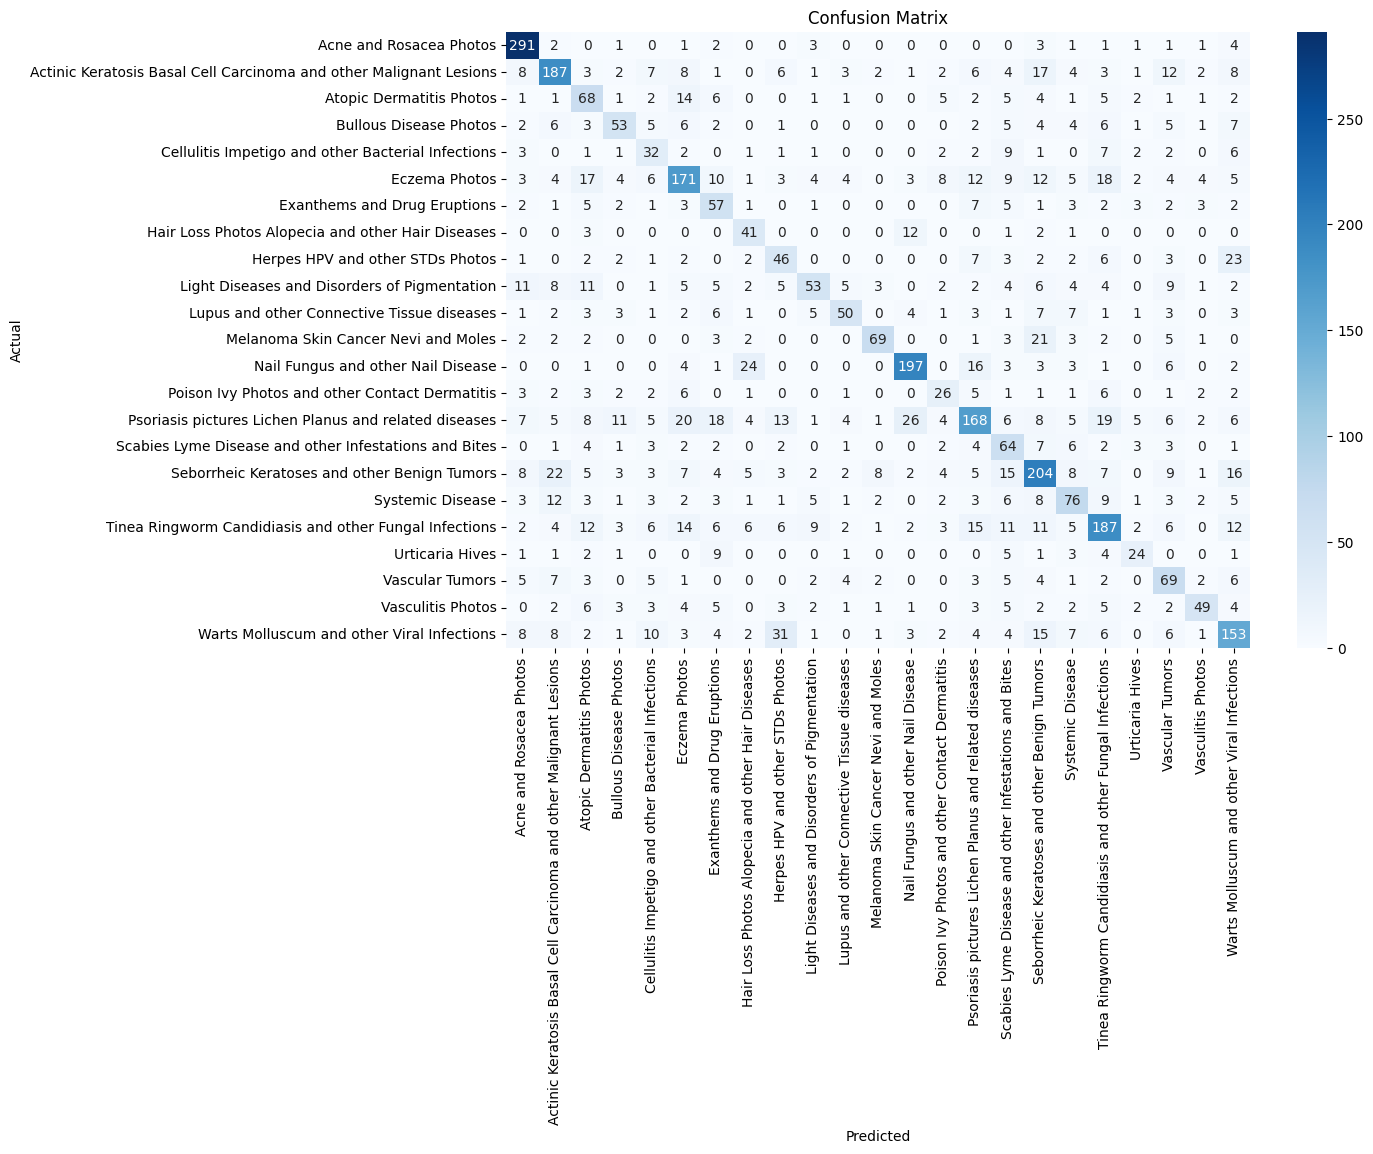

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test dataset
test_results = ensemble_model.evaluate(test_data)

# Display test results dynamically based on length
print(f"Test Results: {test_results}")

# If at least loss and accuracy are returned, extract them
test_loss = test_results[0] if len(test_results) > 0 else None
test_accuracy = test_results[1] if len(test_results) > 1 else None

# Print extracted values
if test_loss is not None:
    print(f"Test Loss: {test_loss:.4f}")
if test_accuracy is not None:
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = ensemble_model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)  # Get the class with highest probability
true_classes = test_data.classes  # True labels
class_labels = list(test_data.class_indices.keys())  # Class names

# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
